In [3]:
import pandas as pd

# Load your raw news data
news_df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')

# Check column names
print(news_df.columns)


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


In [7]:
# Convert to datetime while allowing mixed formats
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed', errors='coerce')

# Drop rows where conversion failed
news_df.dropna(subset=['date'], inplace=True)



In [8]:
# Filter for Apple headlines (assuming stock ticker is 'AAPL' or similar)
news_df = news_df[news_df['stock'] == 'A']  # Adjust if needed


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Apply sentiment score to each headline
news_df['sentiment'] = news_df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


In [10]:
# Group by date and compute mean sentiment
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()


In [13]:
stock_df = pd.read_csv('../data/yfinance_data/AAPL_historical_data.csv')  # Replace with actual filename if different



In [14]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date  # So it matches `news_df['date'].dt.date`


In [19]:
# Ensure both dates are timezone-naive and just the date part
news_df['date'] = pd.to_datetime(news_df['date']).dt.tz_localize(None).dt.date
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date


In [20]:
# Group by news date and calculate average sentiment
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()

# Merge with stock data
merged_df = pd.merge(stock_df, daily_sentiment,
                     left_on='Date', right_on='date', how='left')


In [21]:
print(merged_df.head())
print(merged_df.columns)


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits date  sentiment  
0        0.0           0.0  NaN        NaN  
1        0.0           0.0  NaN        NaN  
2        0.0           0.0  NaN        NaN  
3        0.0           0.0  NaN        NaN  
4        0.0           0.0  NaN        NaN  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'date', 'sentiment'],
      dtype='object')


In [22]:
print(merged_df['sentiment'].isna().sum())


10994


In [23]:
merged_df['sentiment'] = merged_df['sentiment'].fillna(method='ffill')


C:\Users\hp\AppData\Local\Temp\ipykernel_8796\472787422.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['sentiment'] = merged_df['sentiment'].fillna(method='ffill')


In [24]:
merged_df['return'] = merged_df['Close'].pct_change()


In [25]:
correlation = merged_df[['sentiment', 'return']].corr()
print(correlation)


           sentiment    return
sentiment   1.000000  0.008909
return      0.008909  1.000000


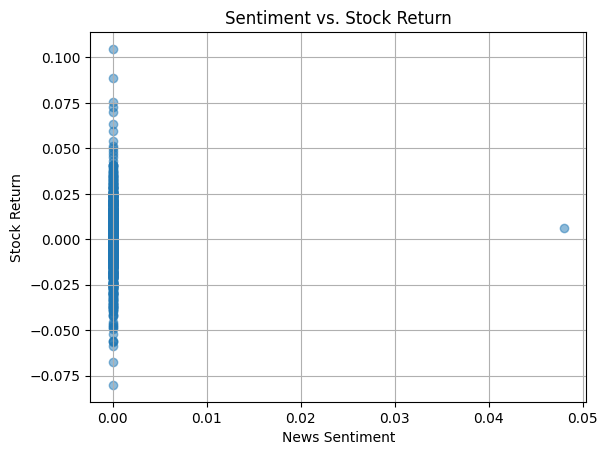

In [26]:
import matplotlib.pyplot as plt

plt.scatter(merged_df['sentiment'], merged_df['return'], alpha=0.5)
plt.xlabel('News Sentiment')
plt.ylabel('Stock Return')
plt.title('Sentiment vs. Stock Return')
plt.grid(True)
plt.show()
